In [235]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np
import joblib


In [236]:
def optimize_hyperparameters(X, y):
    # Initialize a BalancedRandomForestClassifier
    clf = RandomForestRegressor()

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [200,500,800],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None]    }

    # Grid search with cross-validation
    grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # For regression
                           cv=3,  # Number of cross-validation folds
                           verbose=2,
                           n_jobs=-1  # Use all available CPUs
                          ) 
    grid_search.fit(X, y)

    # Return best parameters and best score
    return grid_search

In [245]:
def plot_regression_results(Y_true, Y_pred, title,path = '/home/marcelo/nico/data_Splus_parameters/result/'):
    """
    Create subplots of true vs predicted values for all features and save them as a PDF.
    
    Parameters:
    - Y_true (DataFrame): Actual values.
    - Y_pred (DataFrame): Predicted values.
    - title (str): Title for the entire set of subplots.
    """
    
    num_columns = len(Y_true.columns)
    
    # Calculate the number of rows needed based on the number of columns
    nrows = -(-num_columns // 2)  # This is a way to compute the ceiling of the division.
    
    # Setting up a grid for the subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    # Flattening the axes array for easy indexing
    axes = axes.ravel()

    # Plot data for each column
    for idx, column in enumerate(Y_true.columns):
        # X-axis: Predicted values, Y-axis: True values
        sc = axes[idx].scatter(Y_pred[column], Y_true[column], cmap='viridis', c=Y_true[column], alpha=0.5)
        
        # Diagonal line
        axes[idx].plot([Y_true[column].min(), Y_true[column].max()],
                       [Y_true[column].min(), Y_true[column].max()],
                       color='red', linestyle='--')
        
        # Set x-axis limits
        axes[idx].set_xlim(Y_pred[column].min(), Y_pred[column].max())
        axes[idx].set_title(column)
        axes[idx].set_xlabel(f'Predicted {column}')
        axes[idx].set_ylabel(f'True {column}')
        axes[idx].grid(True)
        fig.colorbar(sc, ax=axes[idx])

    # Remove any unused subplots
    for i in range(num_columns, nrows*2):
        fig.delaxes(axes[i])

    # Save the figure to a PDF file
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.savefig(f'{path}{title}.pdf')





In [246]:
def preprocess_features(data,columns,bad_values):
    """
    Realiza el preprocesamiento de las características especificadas.

    Args:
    - data (pd.DataFrame): DataFrame original con los datos.

    Returns:
    - data (pd.DataFrame): DataFrame procesado con características adicionales y filas inválidas eliminadas.
    """
    
    # Busca valores 999 o -999 en las columnas especificadas
    invalid_values = data[columns].isin([bad_values, -bad_values]).sum()

    # Filtra y muestra solo las columnas que tienen estos valores inválidos
    columns_with_invalids = invalid_values[invalid_values > 0]

    if columns_with_invalids.empty:
        print(f" Todas las columnas tienen datos válidos, sin valores {bad_values} o -{bad_values}.")
    else:
        print(f"Las siguientes columnas tienen valores {bad_values} o -{bad_values}:\n{columns_with_invalids}")

    # Filtra el DataFrame para excluir filas con valores 999 o -999 en las columnas especificadas
    data = data[~data[columns].isin([bad_values, -bad_values]).any(axis=1)].reset_index(drop=True)

    return data

In [247]:
file_names = [
    "Apogee-Colors-Dwarfs",
    "Galah-Colors-Giants",
    "Apogee-Colors-Giants",
    "LamostMedium-Colors-Dwarfs",
    "Galah-Colors-Dwarfs",
    "LamostMedium-Colors-Giants"
]


Las siguientes columnas tienen valores 999 o -999:
FE_H          6
ALPHA_M      13
C_FE         58
CA_FE        37
N_FE       1784
NI_FE        17
MG_FE         9
SI_FE        16
dtype: int64
 Todas las columnas tienen datos válidos, sin valores 9999 o -9999.
Las siguientes columnas tienen valores 0 o -0:
u-J378       12
u-J395       13
u-J410       10
u-J515        1
u-J660        3
u-J861        2
J378-J395    16
J378-J410    11
J378-J430     1
J378-J660     2
J378-J861     1
J395-J410    11
J395-J430     3
J395-J660     2
J395-J861     2
J410-J430     3
J410-J515     2
J410-J660     3
J410-J861     1
J430-J515     1
J430-J861     1
J515-J660     1
r-J660        3
r-i           1
r-J861        1
J660-i        2
J660-J861     2
i-J861        6
i-z           1
J861-z        5
dtype: int64
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Todas las columnas tienen datos válidos, sin valores 999 o -999.
 Todas las columnas tienen datos válidos, sin valores 9999 o -9999.
Las s

KeyboardInterrupt: 

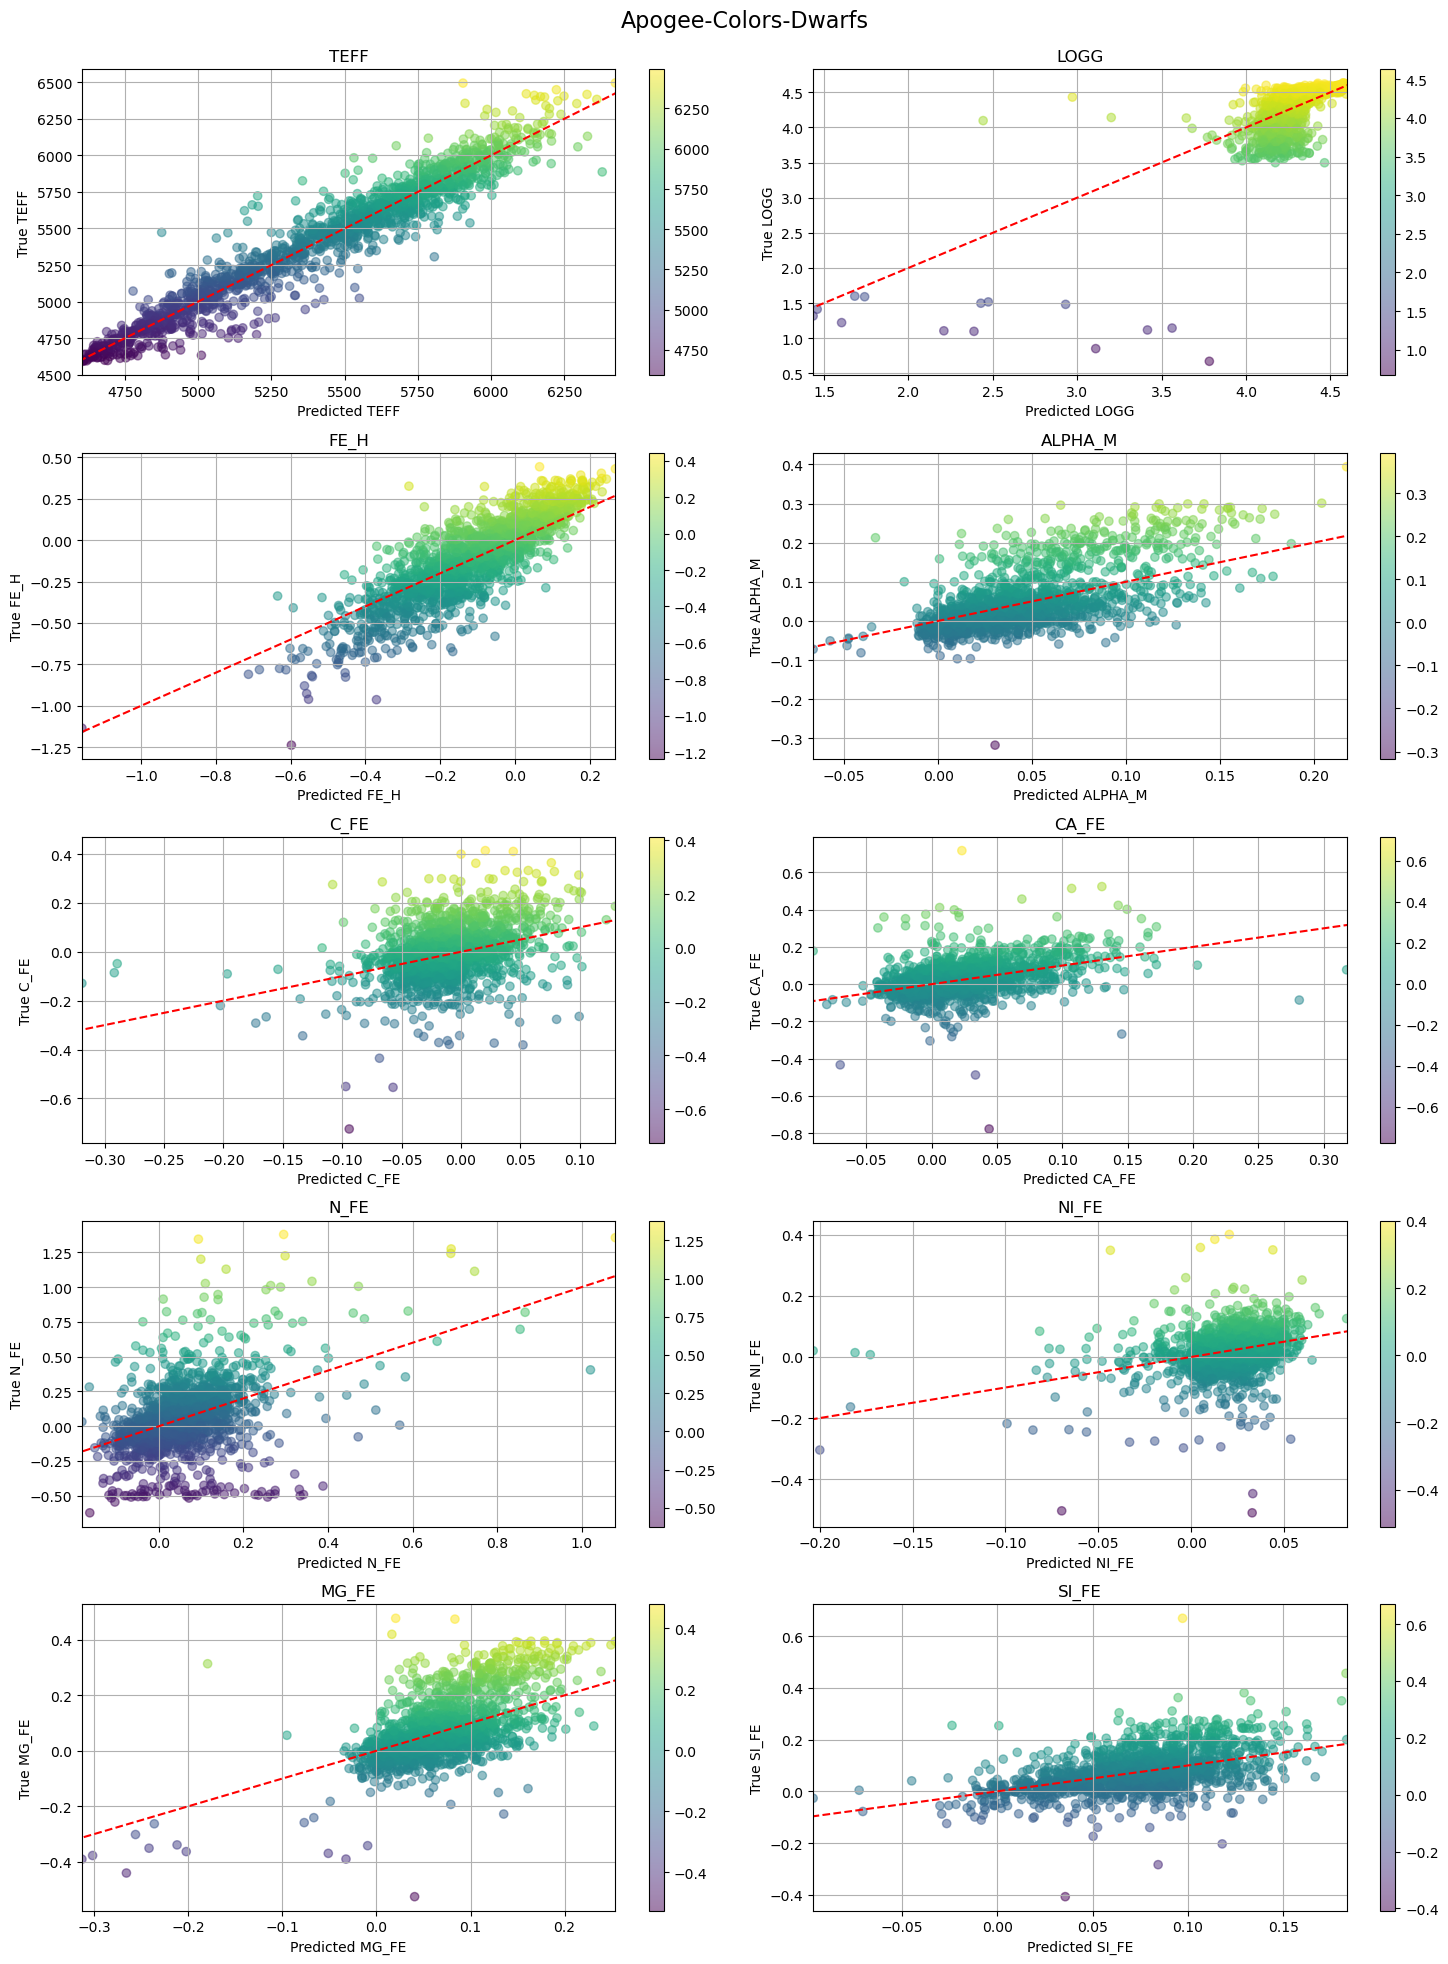

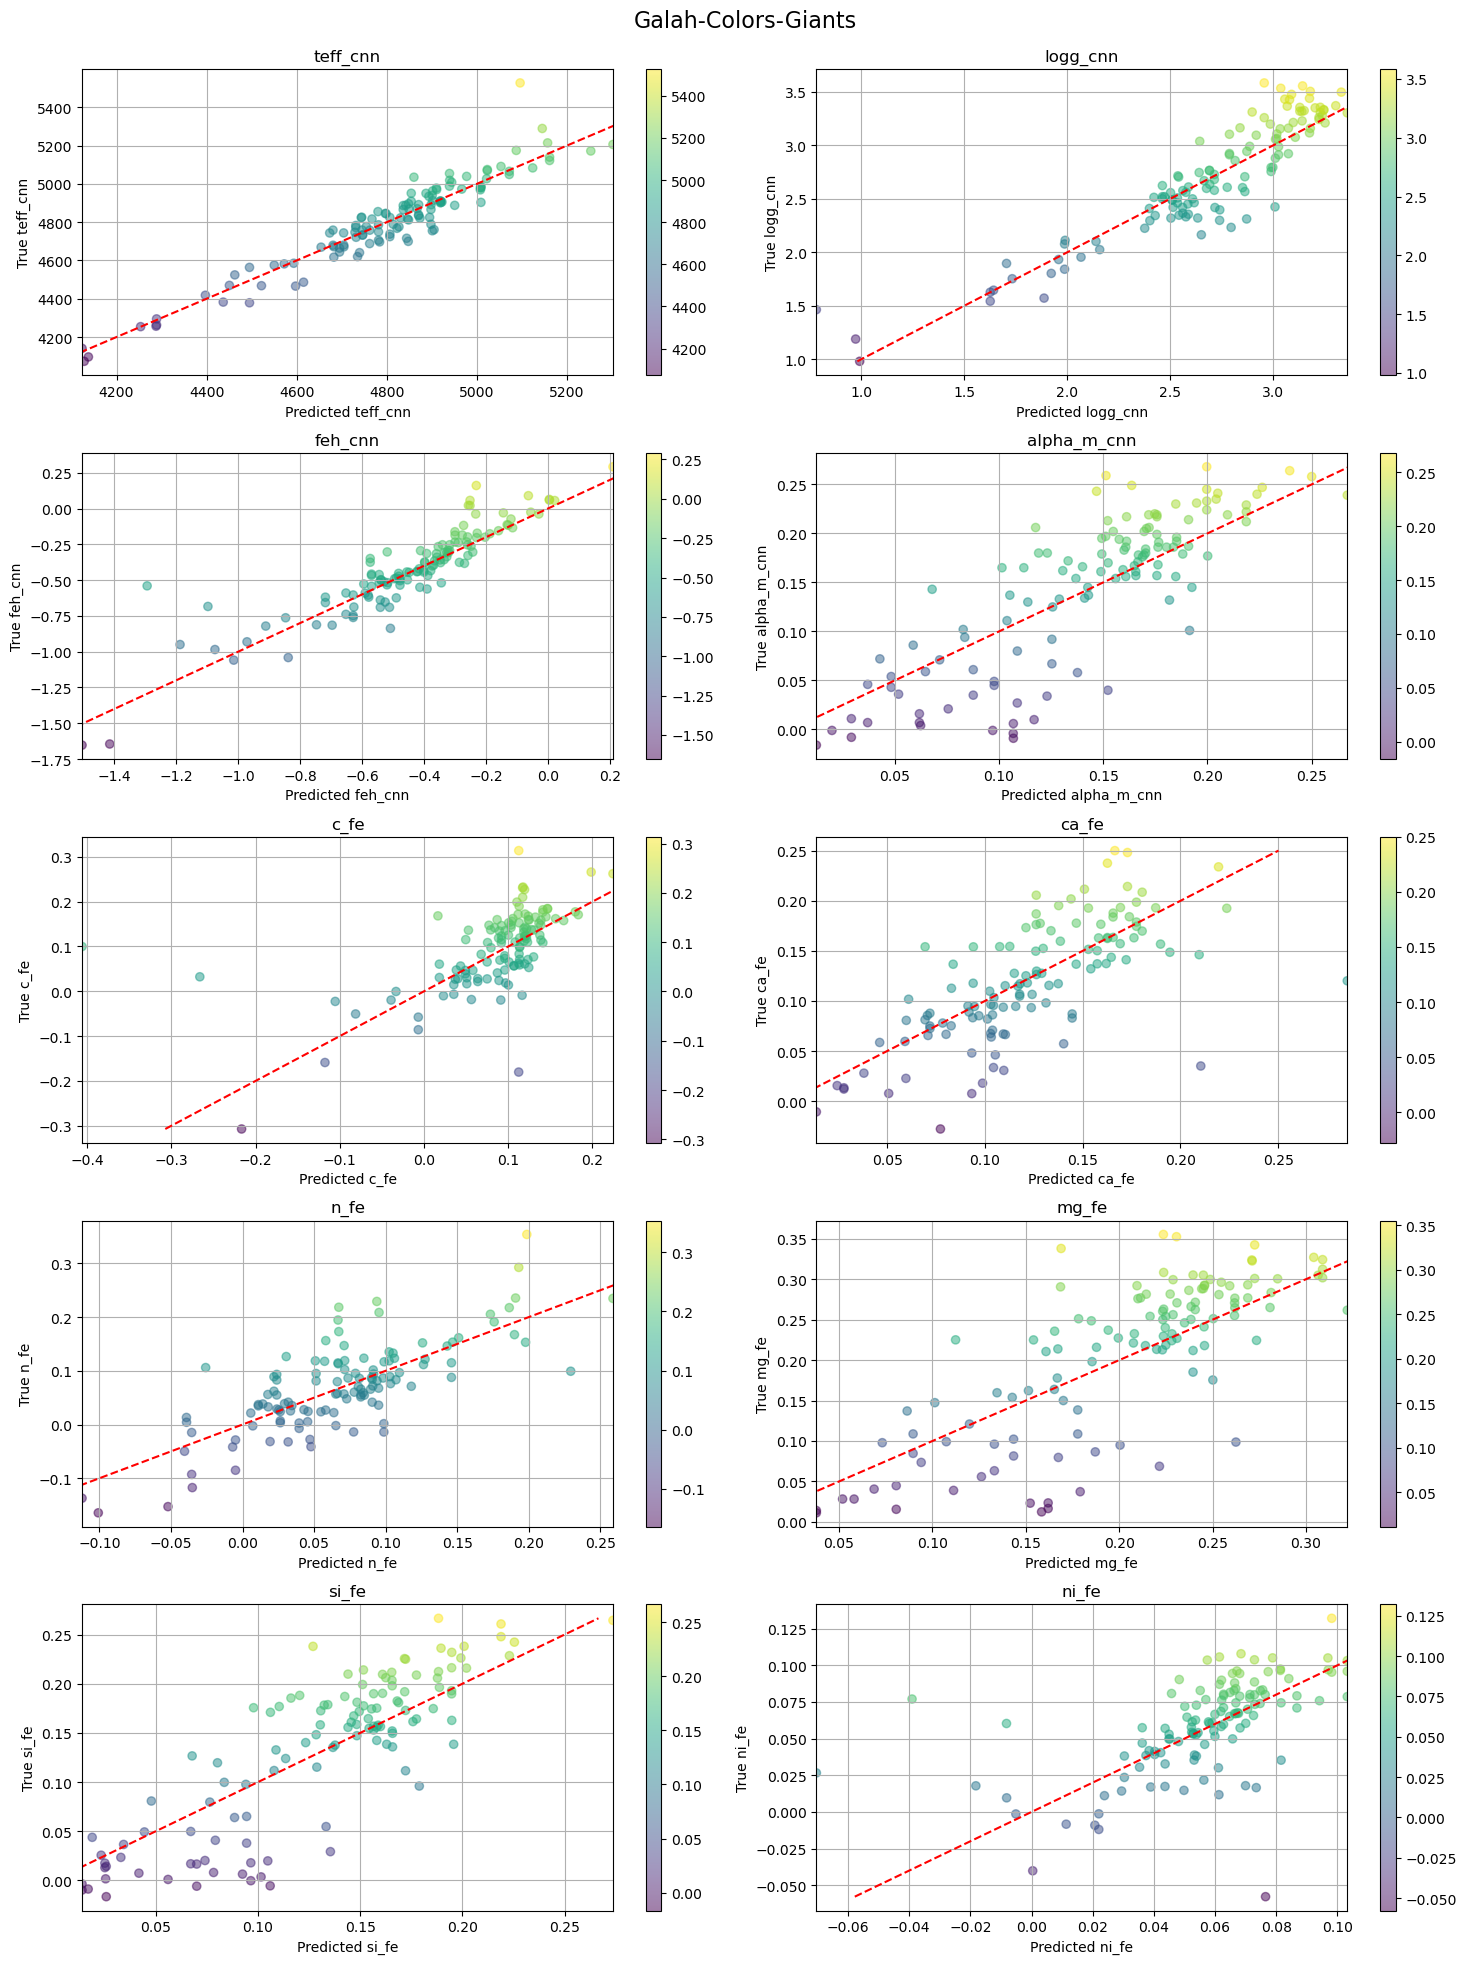

In [248]:
for i in file_names:
    test = i
    AnasCores = pd.read_csv(f'/home/marcelo/nico/data_Splus_parameters/Filtered_Training_Set/{test}.csv')
    AnasCores = preprocess_features(AnasCores,AnasCores.columns,999)
    AnasCores = preprocess_features(AnasCores,AnasCores.columns,9999)
    AnasCores = preprocess_features(AnasCores,AnasCores.columns,0)
    xtrain = AnasCores.iloc[:, 1:67]
    columnYtrain = AnasCores.columns[67:]
    ytrain = AnasCores[columnYtrain]
    X_train, X_test, Y_train, Y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=11085)
    grid_search = optimize_hyperparameters(X_train,Y_train)
    pd.DataFrame([best_params]).to_csv(f'/home/marcelo/nico/data_Splus_parameters/result/best_param_{test}.csv',index=False)
    rf_regressor = RandomForestRegressor(**best_params)
    rf_regressor.fit(X_train, Y_train)
    filename = f'/home/marcelo/nico/data_Splus_parameters/result/{test}.sav'
    joblib.dump(rf_regressor, filename)
    #rf_regressor = joblib.load(filename) this is to load the random forest model
    y_pred = rf_regressor.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns)
    plot_regression_results(Y_test, y_pred_df, test)

In [222]:
test = 'LamostMedium-Colors-Giants'

In [223]:
AnasCores = pd.read_csv(f'/home/marcelo/nico/data_Splus_parameters/Filtered_Training_Set/{test}.csv')

In [224]:
AnasCores = preprocess_features(AnasCores,AnasCores.columns,999)
AnasCores = preprocess_features(AnasCores,AnasCores.columns,9999)
AnasCores = preprocess_features(AnasCores,AnasCores.columns,0)

 Todas las columnas tienen datos válidos, sin valores 999 o -999.
Las siguientes columnas tienen valores 9999 o -9999:
alpha_m_cnn    359
c_fe           359
ca_fe          359
n_fe           359
mg_fe          359
si_fe          359
ni_fe          359
dtype: int64
Las siguientes columnas tienen valores 0 o -0:
alpha_m_cnn    1
dtype: int64


In [225]:
# con 66 Falta el 'J861-z' y hay que agregar el 1 para no introducir el ID al entrenamiento
xtrain = AnasCores.iloc[:, 1:67]
columnYtrain = AnasCores.columns[67:]
ytrain = AnasCores[columnYtrain]
X_train, X_test, Y_train, Y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=11085)

In [226]:
grid_search = optimize_hyperparameters(X_train,Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [227]:
pd.DataFrame([best_params]).to_csv(f'best_param_{test}.csv',index=False)

In [228]:
rf_regressor = RandomForestRegressor(**best_params)
rf_regressor.fit(X_train, Y_train)
filename = f'{test}.sav'
joblib.dump(rf_regressor, filename)

['LamostMedium-Colors-Giants.sav']

In [229]:
#rf_regressor = joblib.load(filename)
y_pred = rf_regressor.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns)

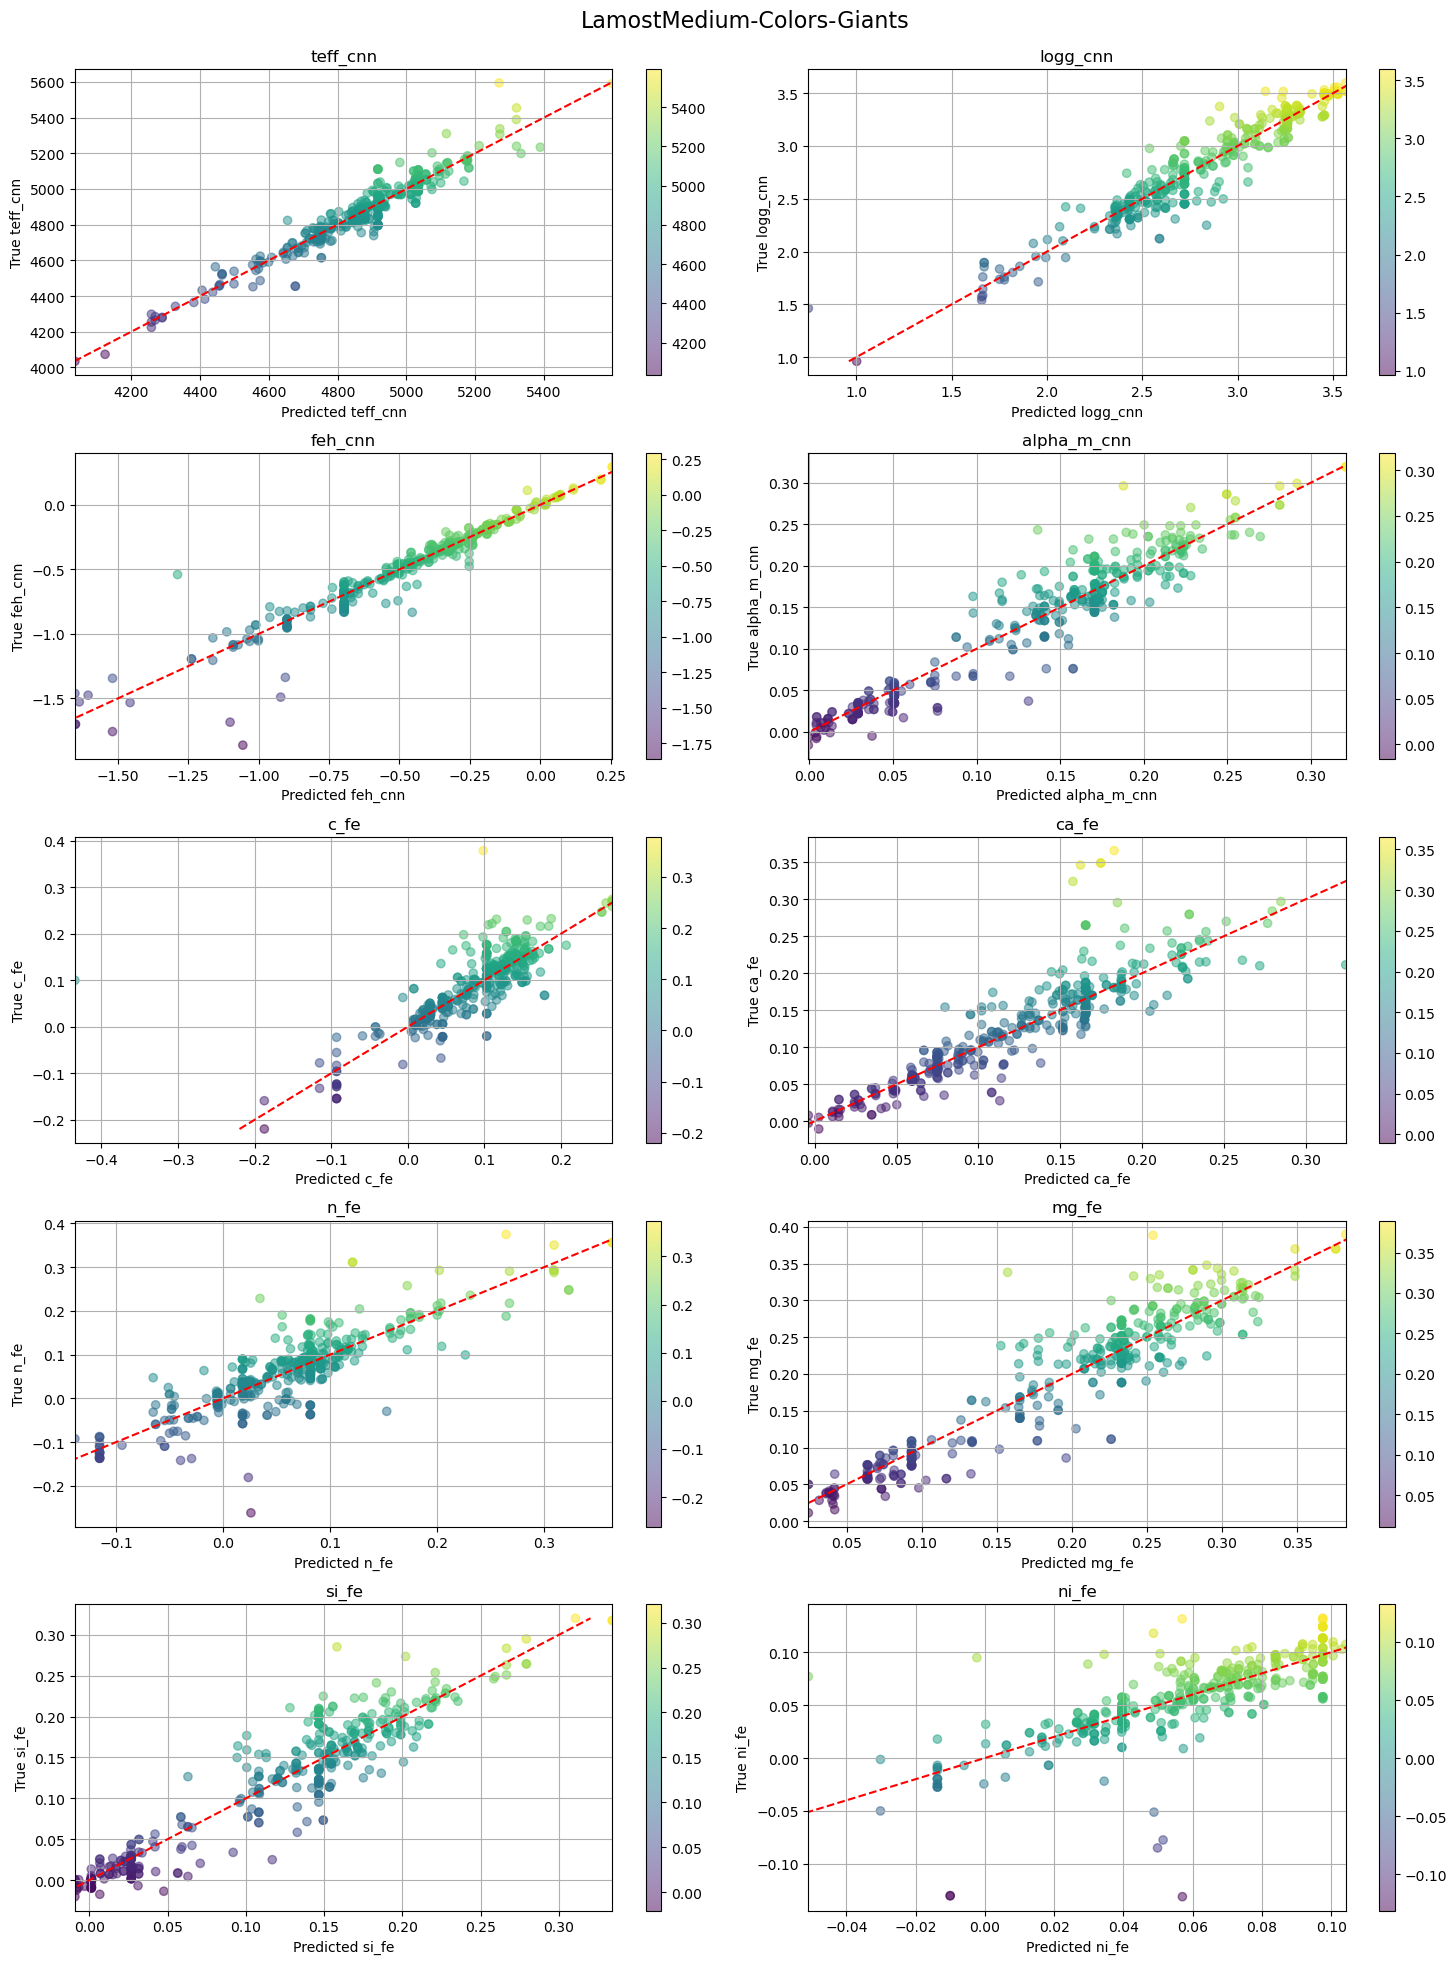

[CV] END max_depth=None, max_features=sqrt, n_estimators=200; total time=   8.7s
[CV] END max_depth=None, max_features=log2, n_estimators=200; total time=   6.8s
[CV] END max_depth=None, max_features=log2, n_estimators=800; total time=  18.3s
[CV] END ..max_depth=10, max_features=log2, n_estimators=500; total time=   1.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=800; total time=   2.9s
[CV] END ..max_depth=30, max_features=log2, n_estimators=800; total time=   2.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   6.9s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   2.8s
[CV] END ..max_depth=20, max_features=log2, n_estimators=800; total time=  11.7s
[CV] END max_depth=None, max_features=sqrt, n_estimators=500; total time=  10.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=200; total time=   6.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   7.8s
[CV] END ..max_depth=20, max

In [230]:
plot_regression_results(Y_test, y_pred_df, test)